In [38]:
import torch
import matplotlib.pyplot as plt
#from common import *
import time
import copy
import gym
from seagul.mesh import mesh_find_target_d
from seagul.mesh import target_d_div, target_d_divn, mdim_div, mesh_dim, identity, target_d_6

import xarray as xr
import numpy as np

import os
import matplotlib

import pybullet_envs
from gym.envs.registration import register

%load_ext autoreload
%autoreload 2


#register(id='A1GymEnv-v1' , entry_point='motion_imitation.envs.gym_envs:A1GymEnv', max_episode_steps=1000)

def do_rollout_push(env, model, magnitude, rate, num_steps=1000, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []


    dtype = torch.float32
    obs = env.reset()
    done = False

    for cur_step in range(num_steps):
        if np.random.uniform() < rate:
            force = np.random.randn(2)
            force = (force / np.linalg.norm(force))*magnitude
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.array([force[0],0,force[1],0,0,0])
            
        if render:
            env.render()
            time.sleep(.01)
        
        obs_list.append(obs)
        
        x_list.append(env.unwrapped.sim.data.qpos[0])


        act,_,_ = model(obs)
        obs, rew, done, _ = env.step(act)
        
        act_list.append((act))
        rew_list.append(rew)


    ep_length = len(rew_list)
    ep_obs = np.stack(obs_list)
    ep_act = np.stack(act_list)
    ep_rew = np.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list


def do_rollout_noise(env, model, obs_std=.001, act_std=.01, num_steps=1000, render=False):
    act_list = []
    obs_list = []
    rew_list = []
    done_list = []

    dtype = np.float32
    obs = env.reset()
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        
        if render:
            env.render()
            time.sleep(.01)
        
        obs += np.random.randn(obs_size)*obs_std
        obs_list.append(np.copy(obs))
        
        #x_list.append(env.unwrapped.sim.data.qpos[0])

        act,_,_,_ = model.step(obs)
        act += np.random.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act)
        
        act_list.append(torch.as_tensor(np.copy(act)))
        rew_list.append(rew)
        
        done_list.append(done)


    ep_length = len(rew_list)
    ep_obs = np.stack(obs_list)
    ep_act = np.stack(act_list)
    ep_rew = np.array(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    return ep_obs, ep_act, ep_rew, done_list

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Variation dimensions

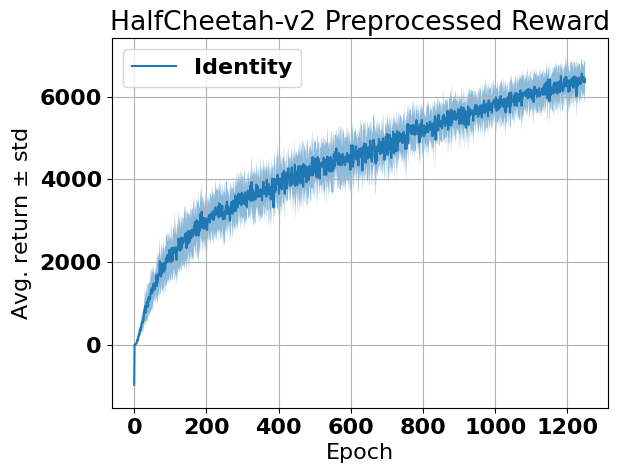

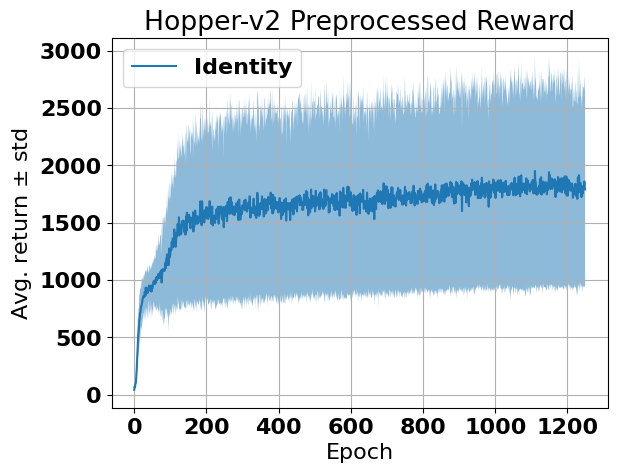

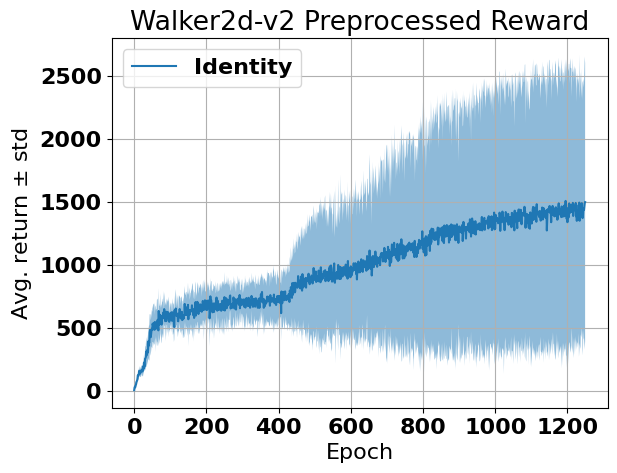

<Figure size 640x480 with 0 Axes>

In [39]:
matplotlib.style.use('default')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

save_dir = "./data_simple/"
env_names = ['HalfCheetah-v2', 'Hopper-v2', 'Walker2d-v2']#, 'Ant-v2','Humanoid-v2']

#env_names = ['Humanoid-v2']

#save_dir = "./data_a1f2/"
#env_names = ["A1GymEnv-v1"]


for env_name in env_names:
    data = torch.load(f"{save_dir}{env_name}/data.xr")
    data = data.where(data.post!='radodiv', drop=True)

    model_dict = data.model_dict
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(model_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    #plt.subplots(1,1, figsize=(10,7))
    plt.plot(means.T)
    plt.legend(['Identity', 'Variogram','Madogram'], loc='upper left')
    ci = stds

    for mean, c in zip(means, ci):
        plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
    plt.title(f"{env_name} Preprocessed Reward")
    plt.ylabel(r"Avg. return $\pm$ std")
    plt.xlabel(r"Epoch")
    plt.grid()
    plt.figure()

#     for exp_name in exp_names:  
#         plt.plot(rews.loc[exp_name].T[:,0:10])
#         plt.title(exp_name)
#         plt.figure()
#     top_seeds = {'identity':[0,1], 'cdim_div':[0,1]}

# Mesh dimensions

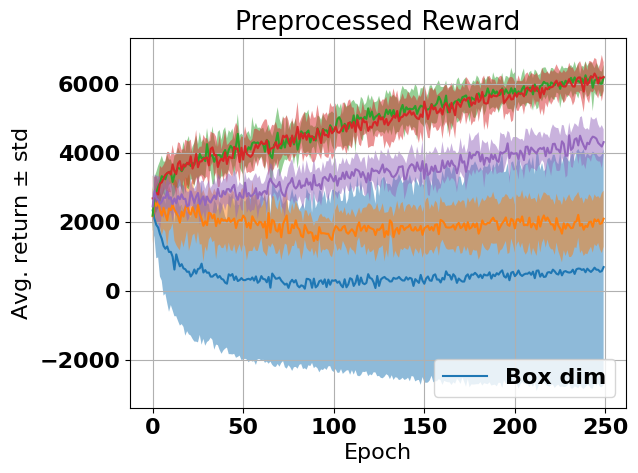

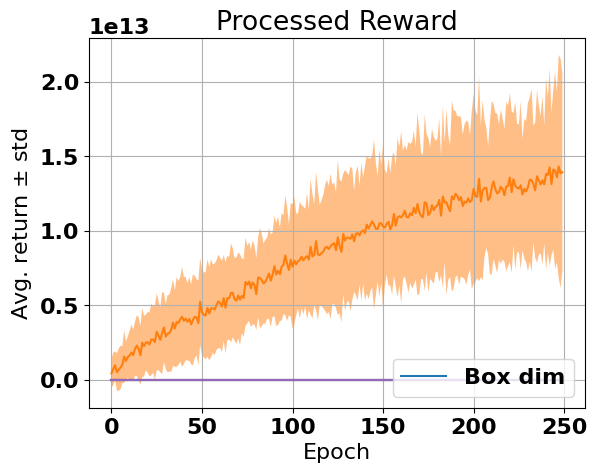

<Figure size 640x480 with 0 Axes>

In [40]:
#env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"]#, "Ant-v2"]
#env_names = ['Humanoid-v2']
#mdim_save_dir = './data_hm0_mdim_long/'

mdim_save_dir = "./data_simple_post/"


matplotlib.style.use('default')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
#init_names = ["identity", "madodiv", "identity", "identity"]
init_names = ["identity"]
for env_name, init_name in zip(env_names, init_names):
    init_data = torch.load(f"{save_dir}{env_name}/data.xr")
    init_model_dict = init_data.model_dict
    
    data = torch.load(f"{mdim_save_dir}{env_name}/data.xr")
    model_dict = data.model_dict
    model_dict['identity'] = init_model_dict['identity']
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(model_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    #plt.subplots(1,1, figsize=(10,7))
    plt.plot(means.T)
    plt.legend(['Box dim'], loc='lower right')
    ci = stds

    for mean, c in zip(means, ci):
        plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
        
    plt.title(f"Preprocessed Reward")
    plt.ylabel(r"Avg. return $\pm$ std")
    plt.xlabel(r"Epoch")
    plt.grid()
    plt.figure()
    
    
    rews = data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(model_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    #plt.subplots(1,1, figsize=(10,7))
    plt.plot(means.T)
    plt.legend(['Box dim'], loc='lower right')
    ci = stds

    for mean, c in zip(means, ci):
        plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
        
    plt.title(f"Processed Reward")
    plt.ylabel(r"Avg. return $\pm$ std")
    plt.xlabel(r"Epoch")
    plt.grid()
    plt.figure()

  

identity
False
[7146.144]
1.1857581536467467 12.051370205330945
0.40817171344812175
False
[6096.6045]
1.2148137492205704 8.249586188407017
1.029401719659866
False
[7121.4683]
1.2442199557464297 9.473487274148571
0.6567654014568052
False
[7091.8945]
1.0096812147381744 6.322233806071836
0.27014762172892093
False
[6412.375]
1.3609136111332027 5.682772514155769
1.0225072503987653
False
[7123.7725]
1.2394044733346496 8.249586188407017
0.430234372711512
False
[5870.577]
1.3403719276913155 6.603568033847861
1.0989758373196925
False
[7299.082]
0.992643178679799 7.4176242964652666
0.3787043691643587
False
[7267.5225]
0.8938900849911279 7.603568033847859
0.2725508810062406
False
[7323.7817]
0.9436251548211163 7.827469119589409
0.2951857448594689
target_d_div
False
[896.76074]
0.07508993440225373 5.0256851026654745
1e-10
False
[4015.3562]
0.20922673626049332 2.223901085741555
1e-10
False
[860.9956]
0.07202003124013023 5.2731623405406465
1e-10
False
[6050.9126]
1.313235552446753 6.464704542171443


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


0.34550219783900715
False
[6202.514]
1.2632453742779735 6.170030668709077


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


0.8083155752147502
False
[6224.992]
1.183405810933634 8.827469119589404


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


0.6896486879326118
False
[6884.616]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


0.17879155236321007 6.603568033847864
2.981232238739729e-07
False
[6048.5576]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


0.2389897664490284 5.025685102665477
1e-10
False
[6253.9556]
1.4978191977273294 6.60356803384787


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


1.0964325071271523
False
[6046.1406]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


0.1696513291602004 3.324542715787147
1e-10
False
[6599.966]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


0.13930813125782326 8.82746911958941
1e-10
False
[5727.4346]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


0.23194706663952933 3.395315503507977
1e-10
False
[7110.0303]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


1.0185043939253182 7.322233806071837
0.263272822000596
mdim_div
False
[6959.304]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


0.9309972582792945 4.866693827124693
0.2938821912782441
False
[5612.788]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


1.027202447829305 6.871173055587394
0.20705431709545757
False
[5864.4727]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


0.8673459080557873 9.421000606173454
0.30264765033882535
False
[6532.2817]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


0.4672550138993103 7.603568033847867
0.14088898907030128
False
[6770.1606]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


0.9269423103774448 8.504739865530713
0.27925282726471845
False
[6048.027]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


1.2046172767885037 8.827469119589418
0.4662266374587717
False
[6800.042]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


1.0330644517794239 8.44905598676978
0.398775637245823
False
[6970.7646]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


0.8858743496183128 8.827469119589411
0.19597798595695748
False
[663.19666]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


0.10970769937169766 5.025685102665473
1e-10
False
[6699.694]
0.8390525891941474 9.042587473353827


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


0.2612158657094179
target_d_6
False
[1277.5073]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


0.08007111472487916 6.025685102665473
1.1623005731143055e-05
False
[4684.4966]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


2.42851415249318 6.4040982354850975
2.503191530791982
False
[5296.3916]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


1.780638203282649 6.5194618849658825
2.7107229829563453
False
[1024.2046]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


0.5322018378762015 6.524648471591381
0.05378454933575977
False
[3654.6543]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


0.08519401023994622 6.908358384105851
1.1109134555751883
False
[5619.8906]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


1.6557735953168757 6.968251960630997
2.735190689636399
False
[4730.366]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


1.4519958191913998 5.861947124147565
2.1617826820203687
False
[5052.3325]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


2.0160348008082702 8.12632673271109
2.4877145887172425
False
[5126.5894]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


1.5734651877958514 6.389740072972058
2.675389349533847
False
[4660.7266]


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


1.788024319672548 7.7960374292848895
2.539220154360039


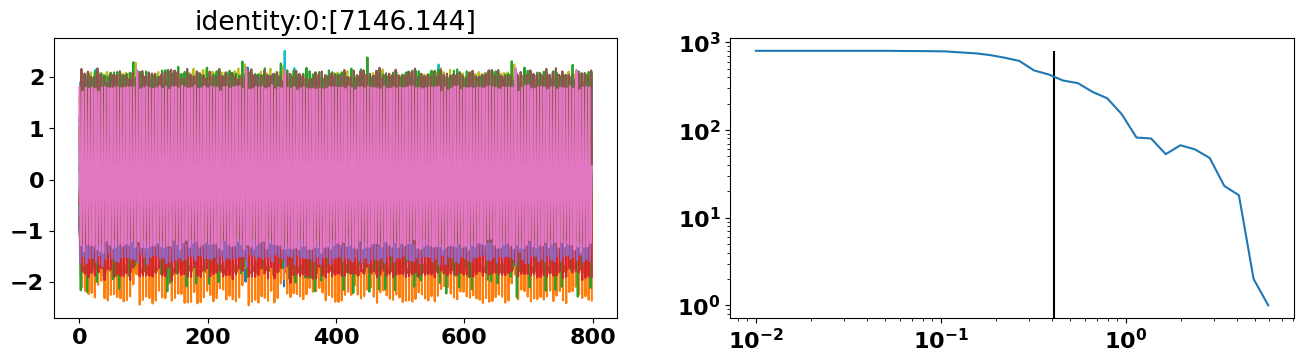

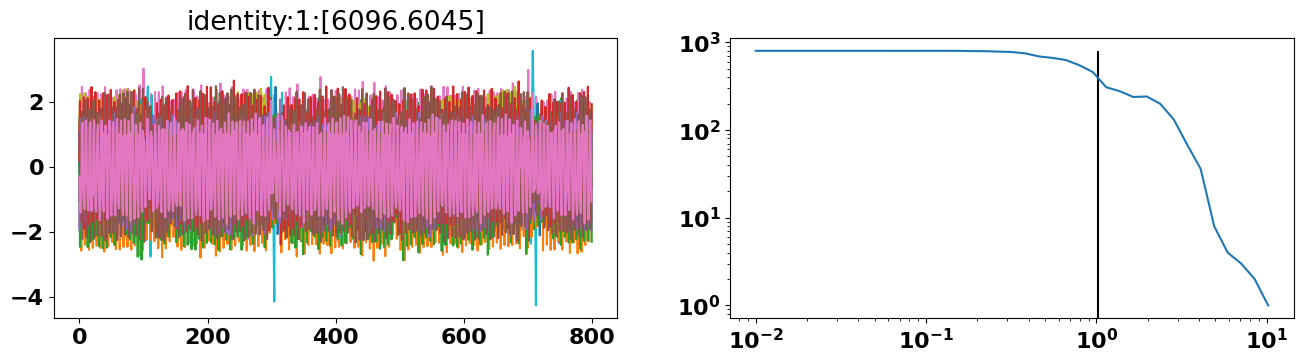

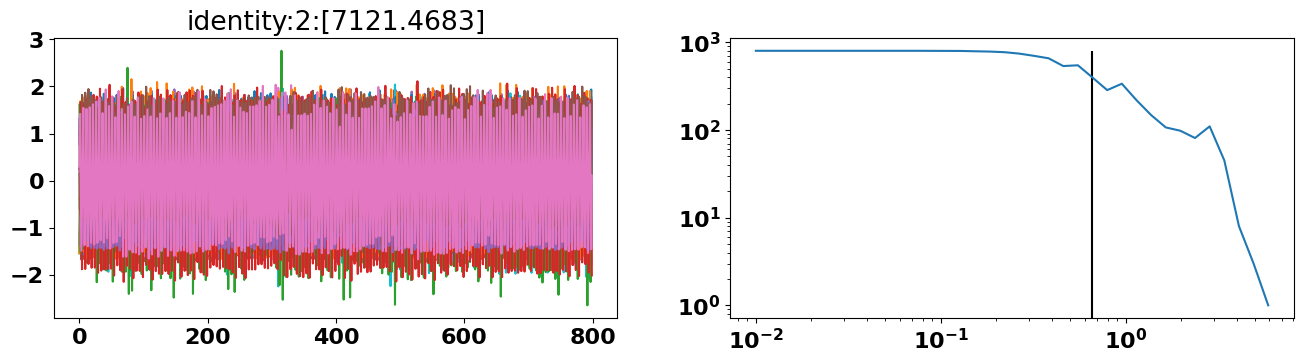

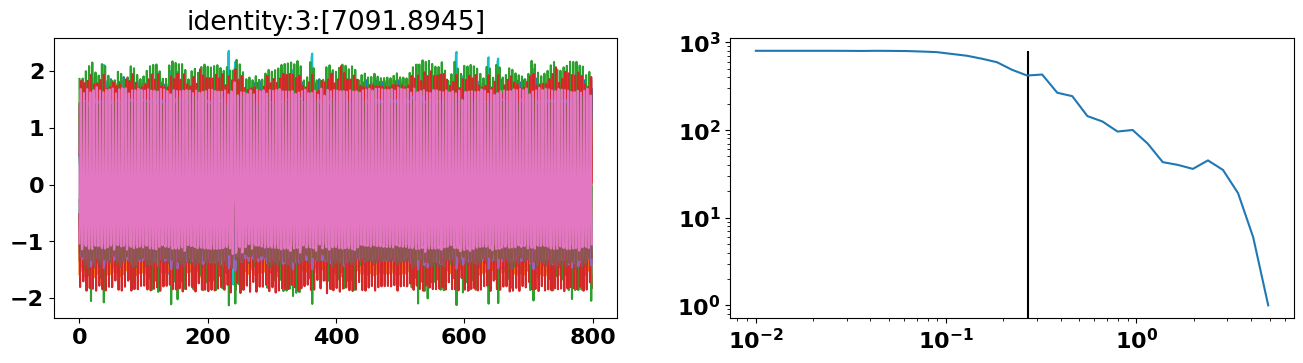

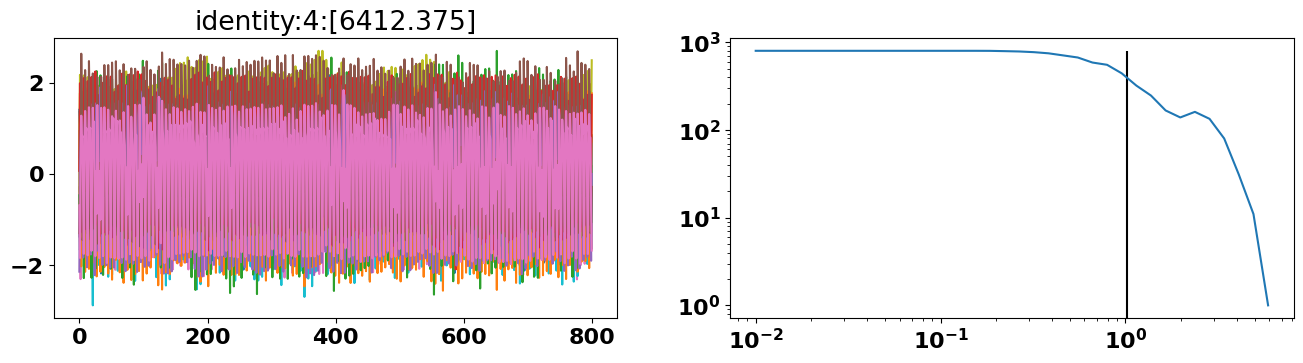

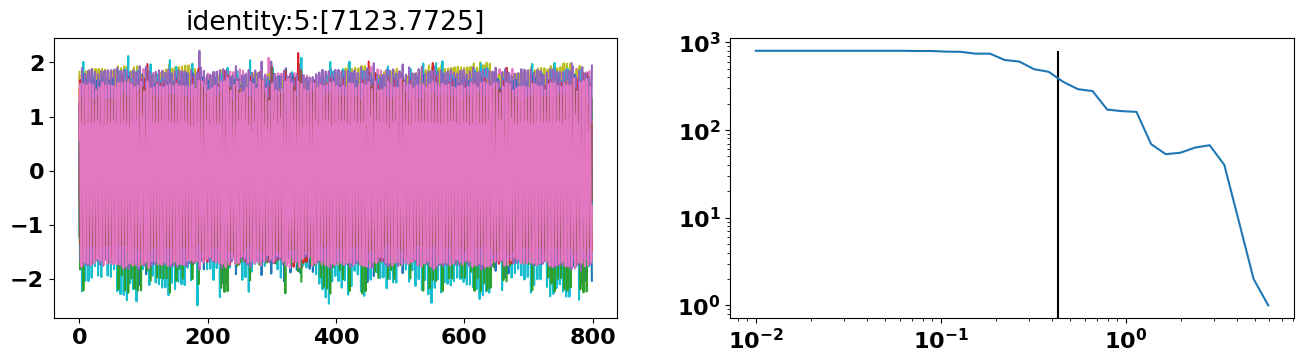

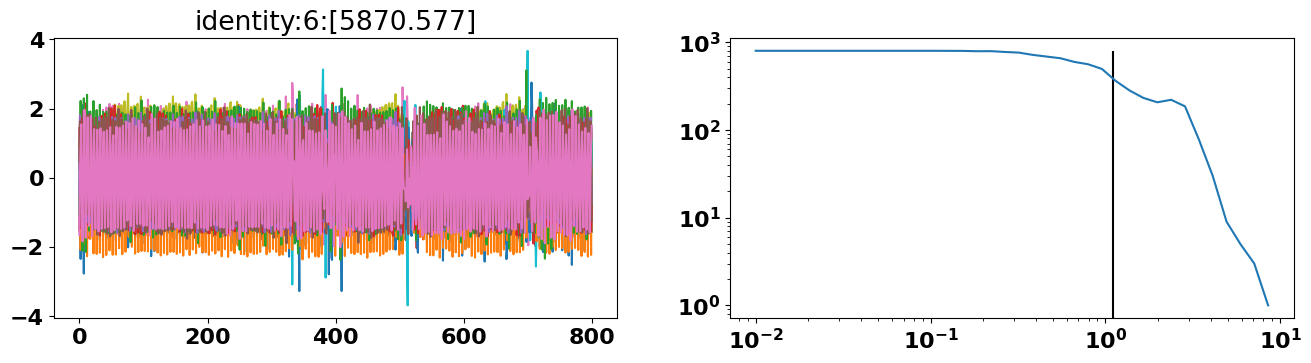

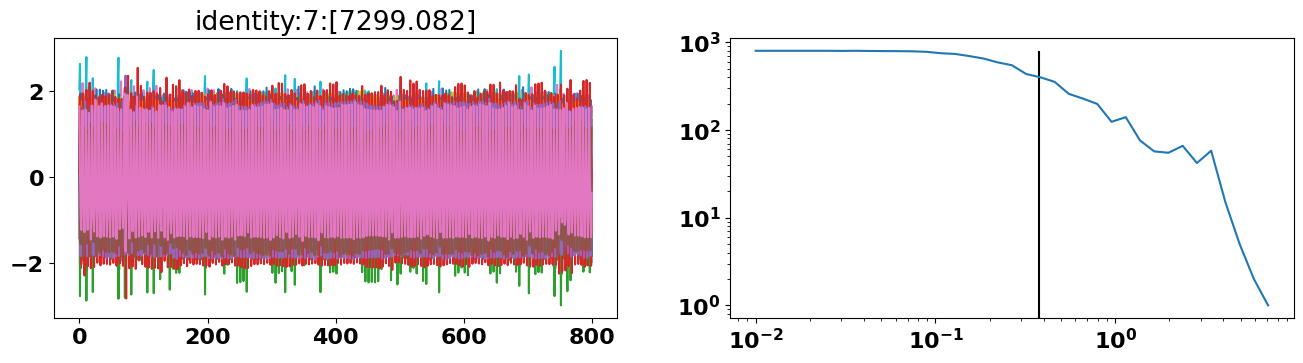

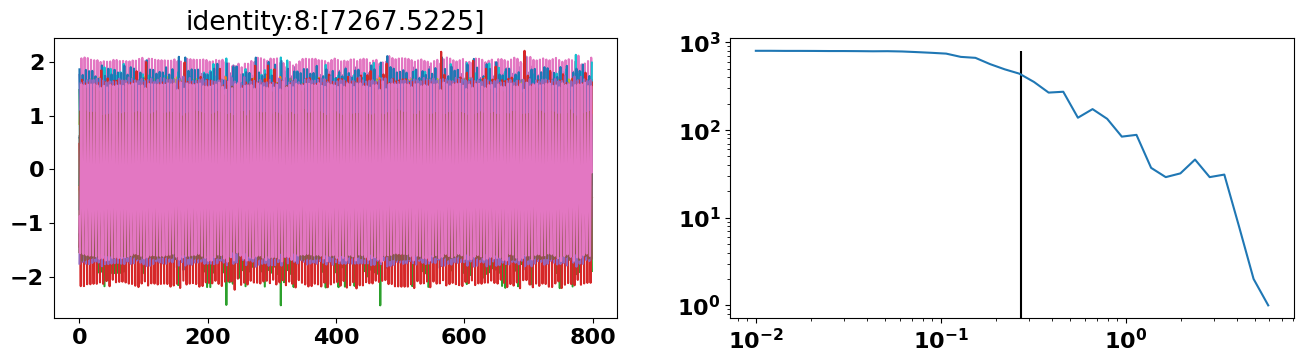

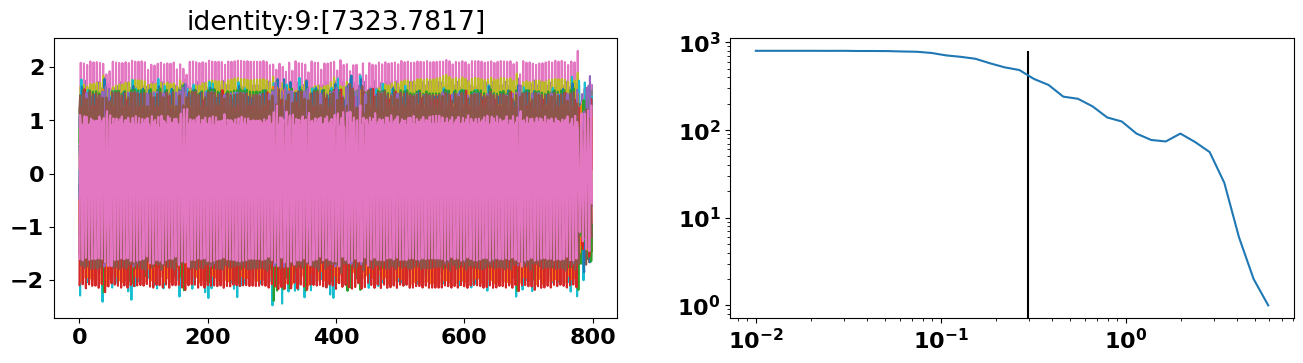

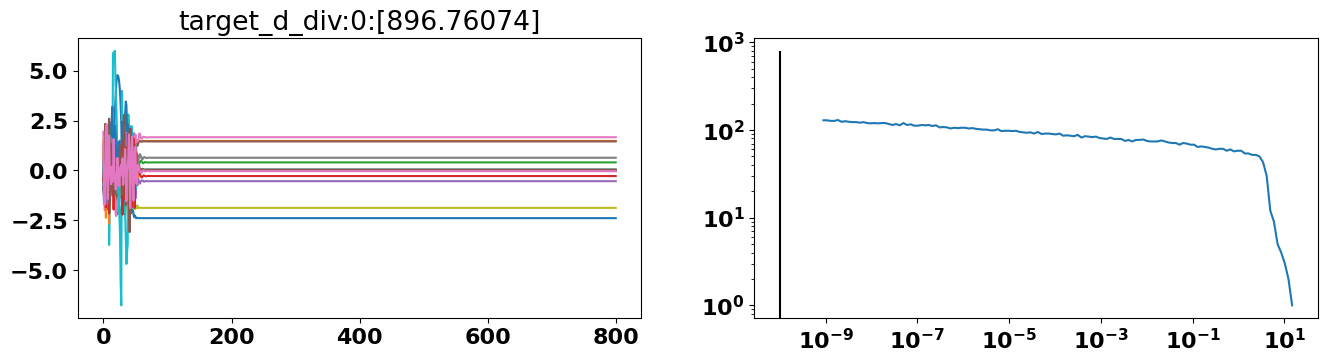

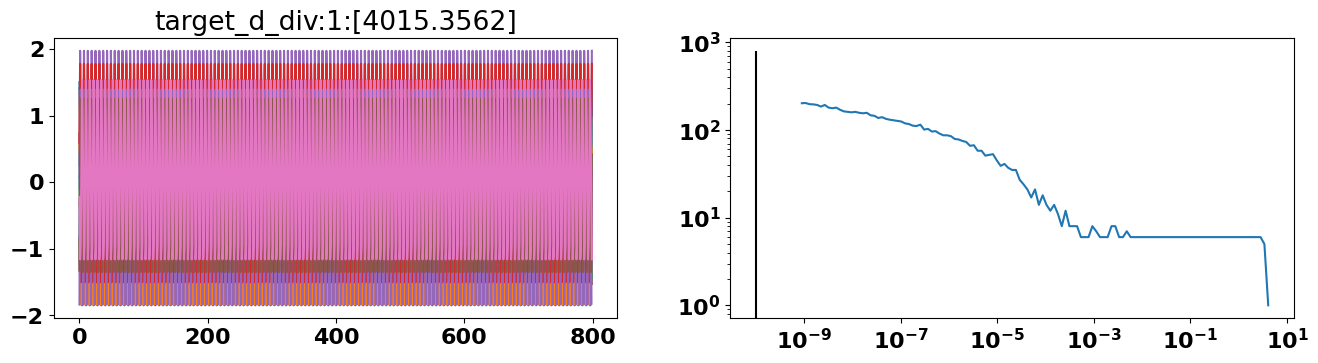

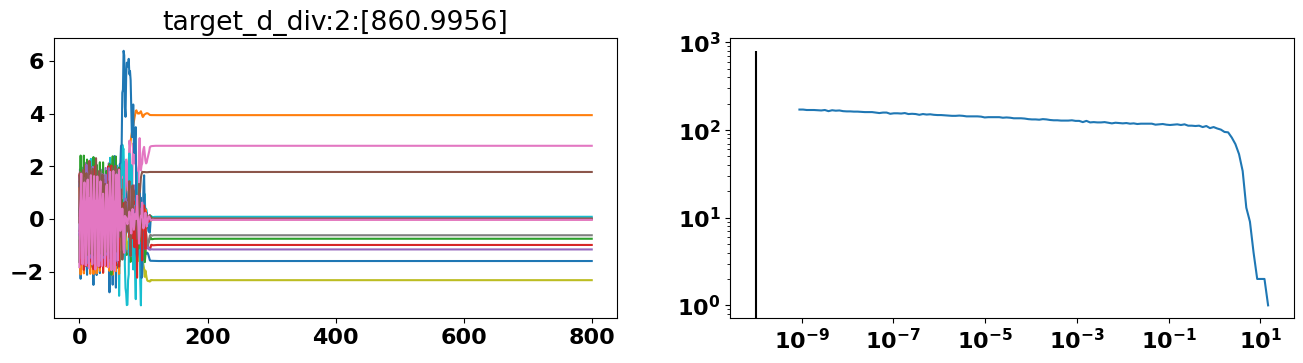

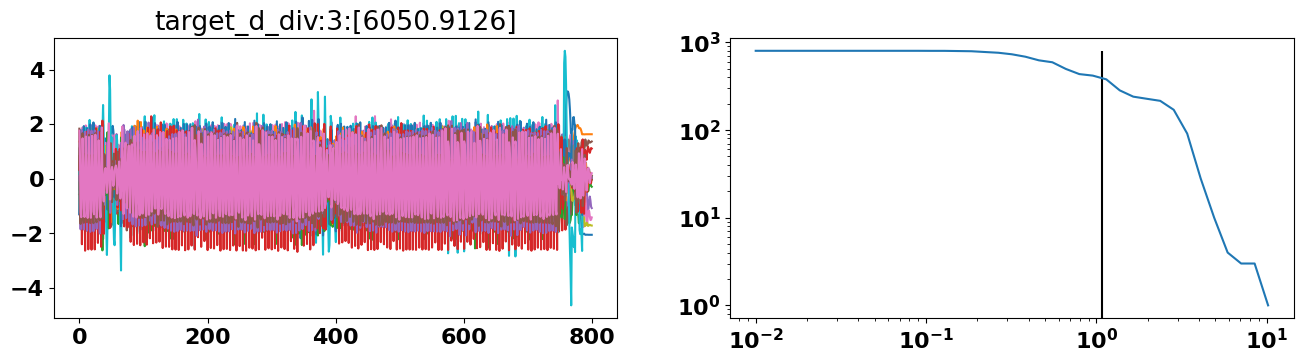

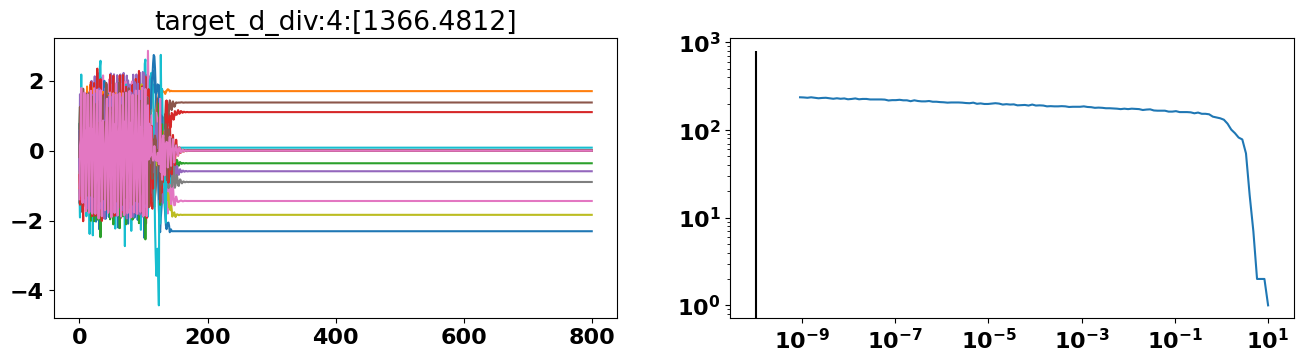

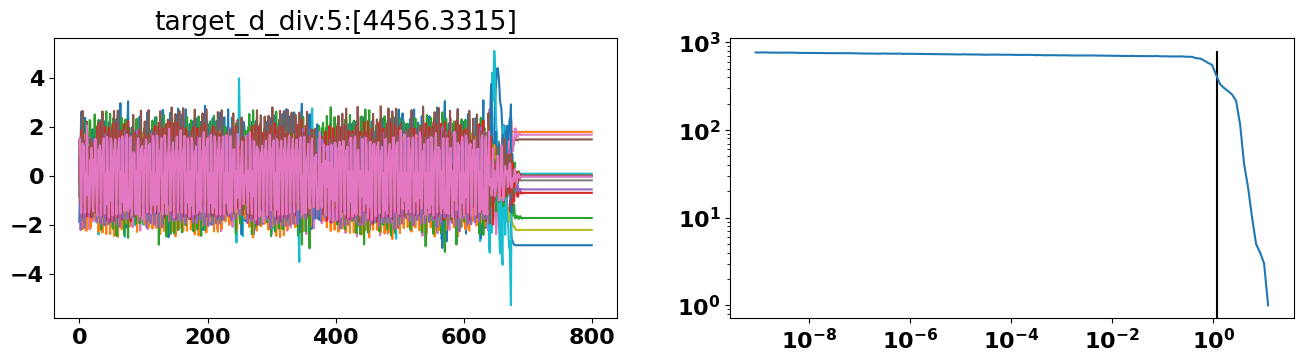

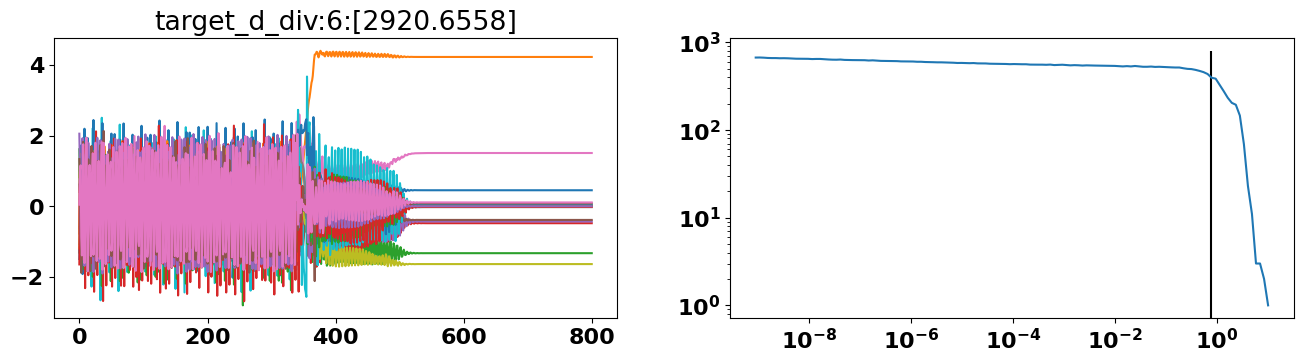

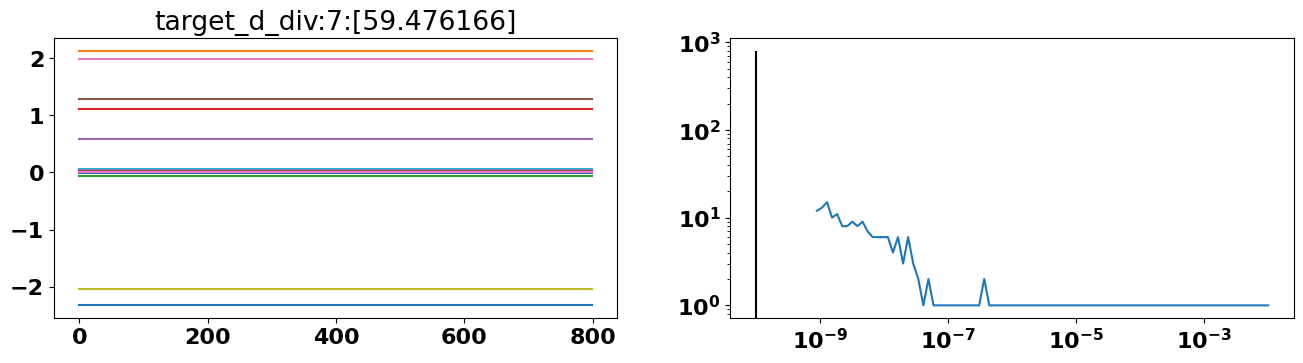

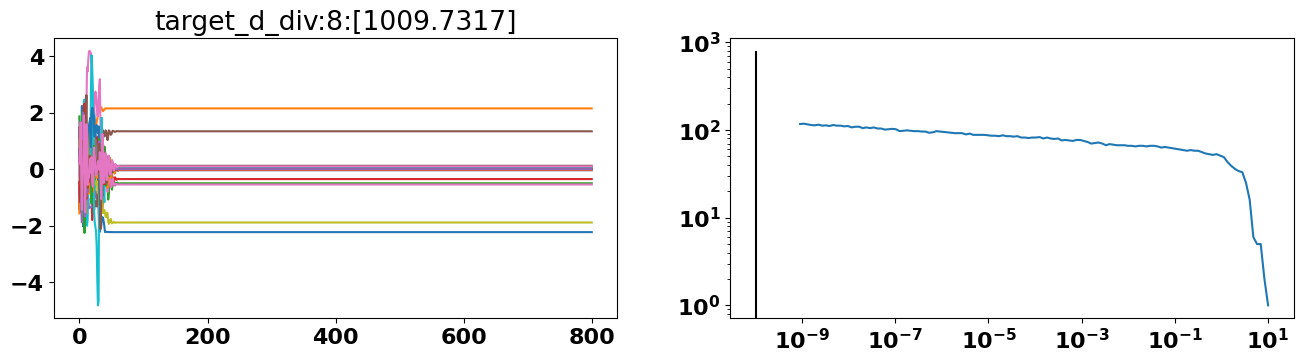

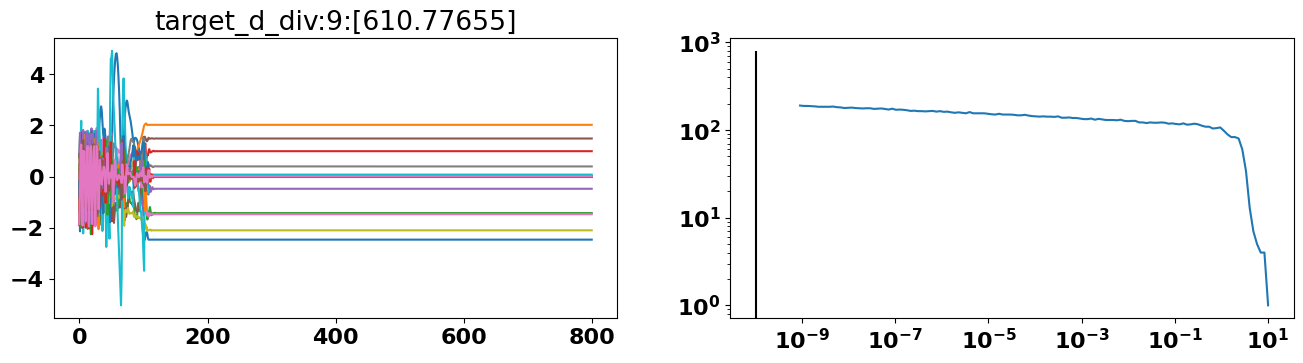

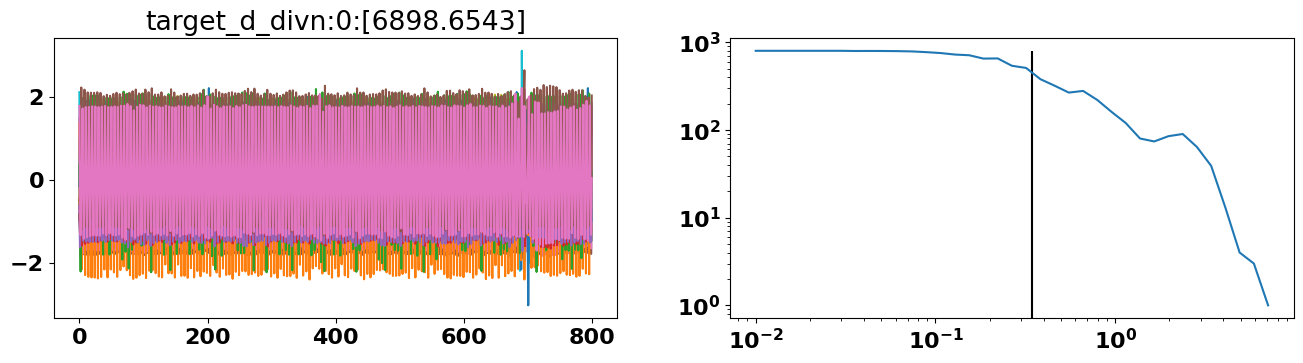

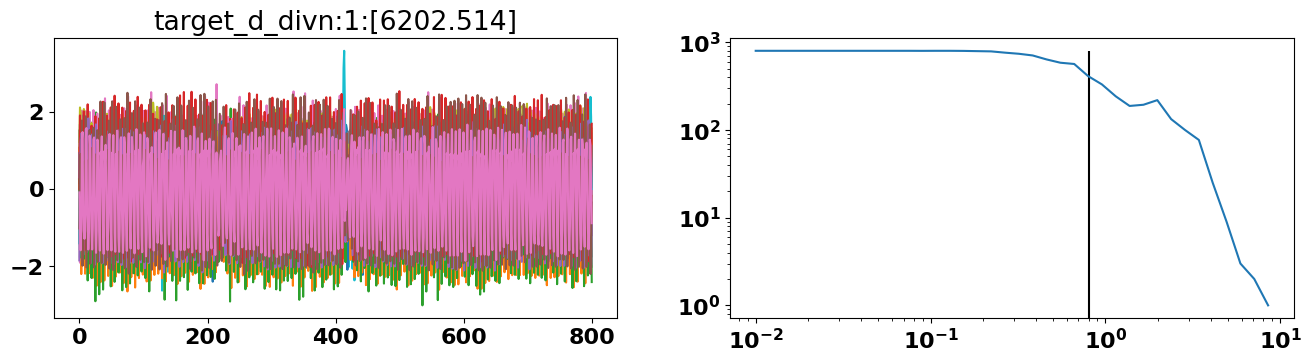

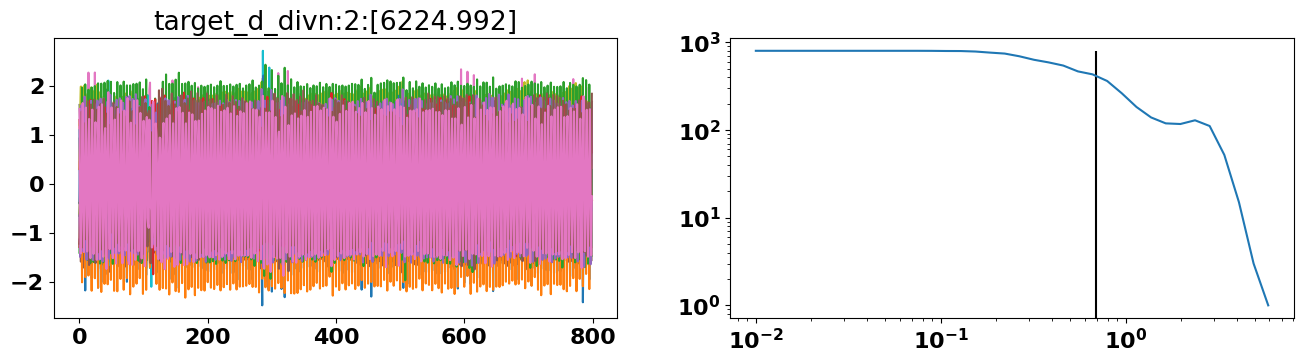

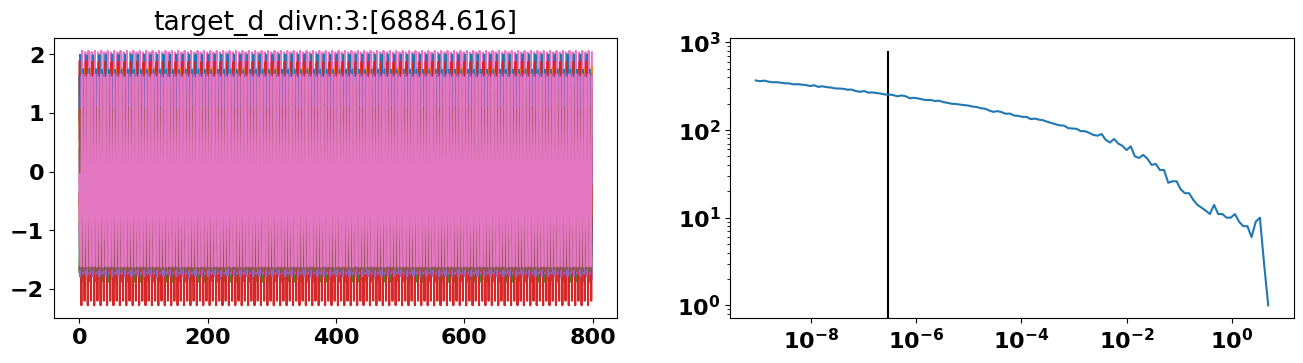

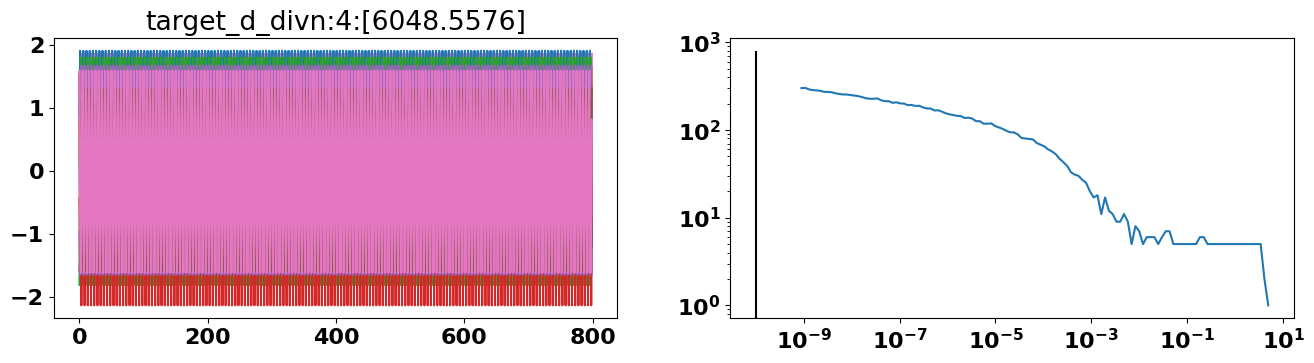

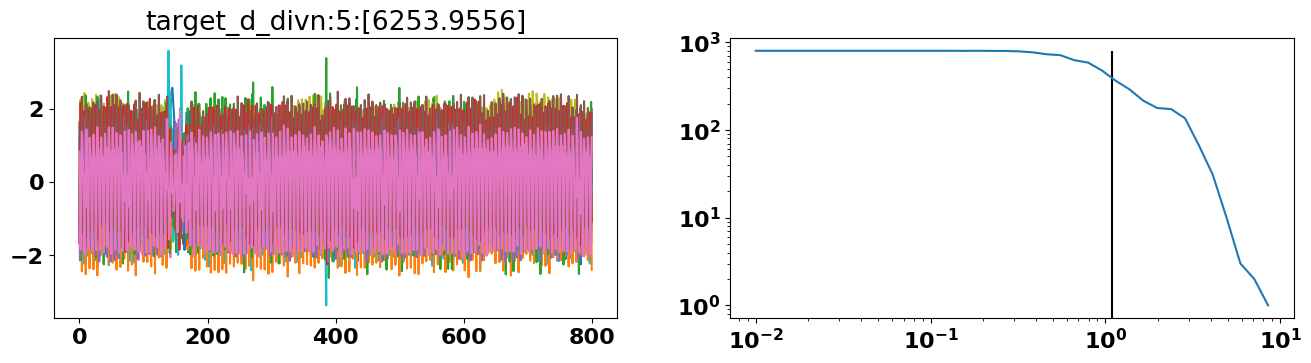

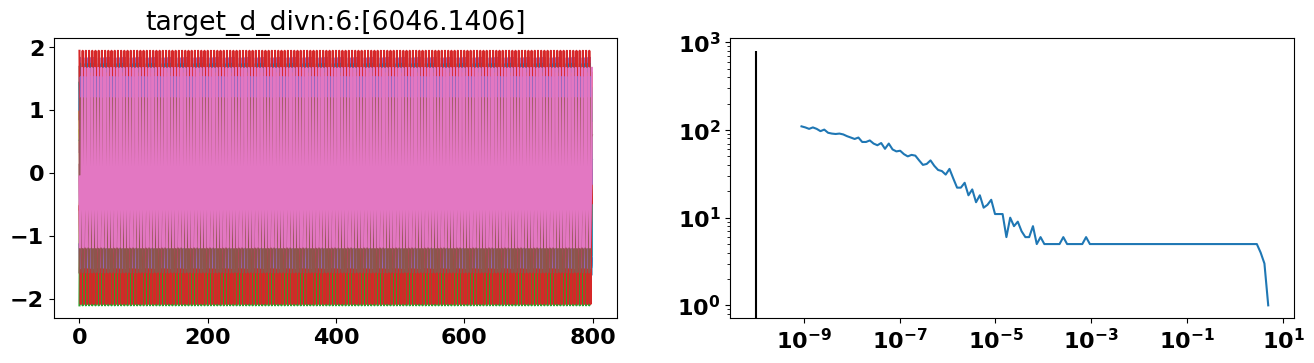

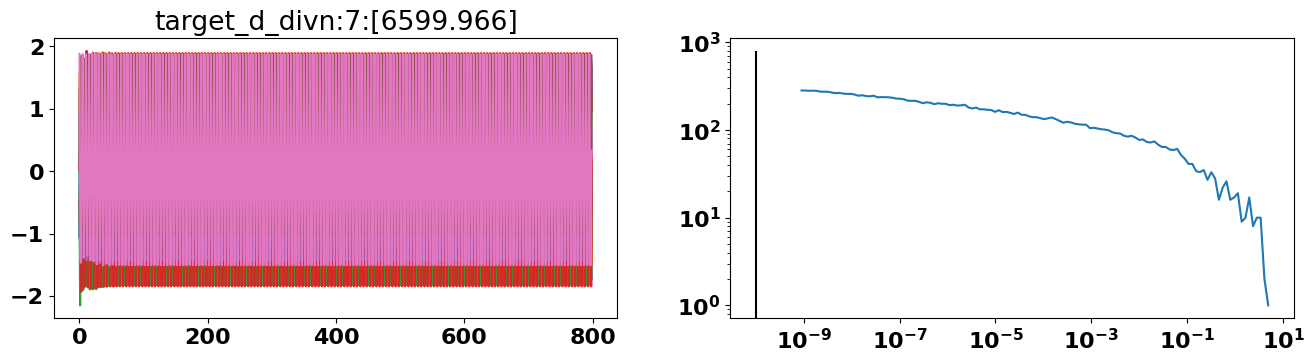

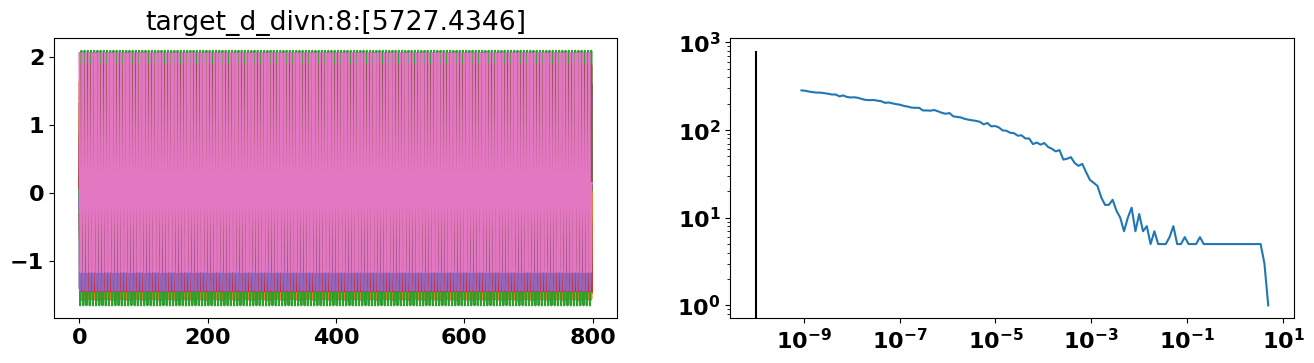

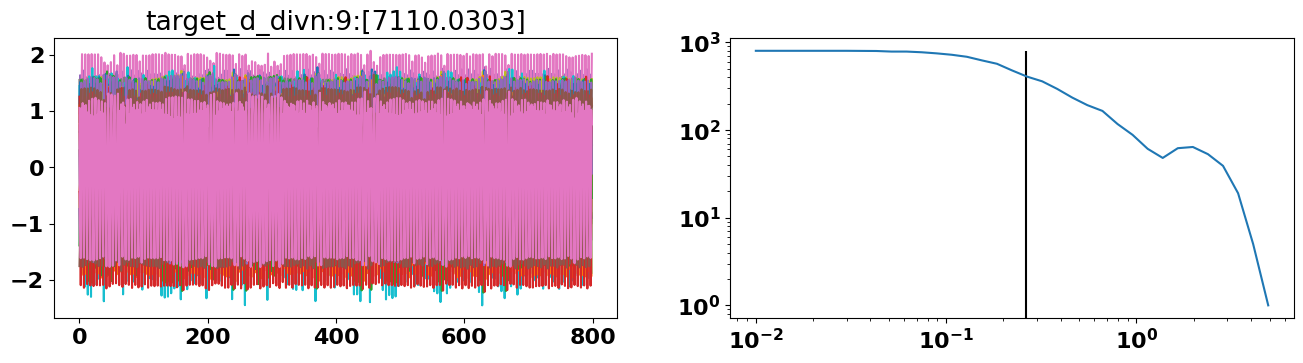

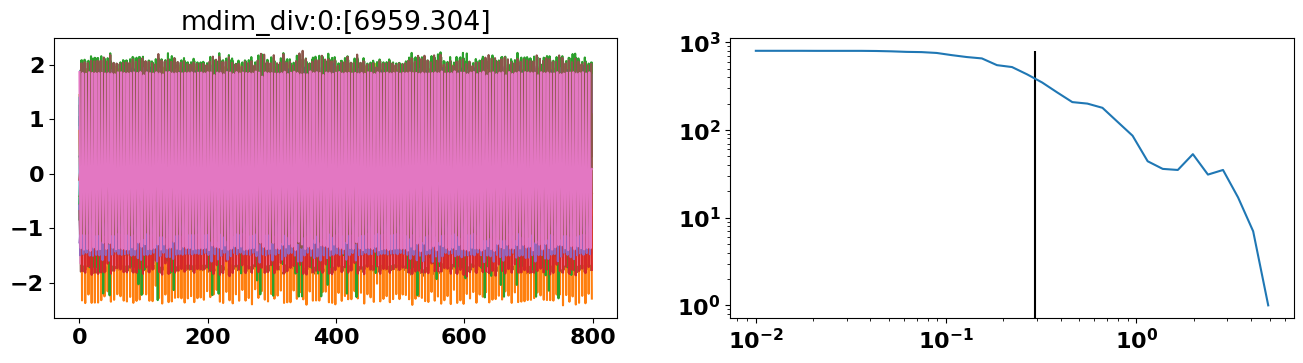

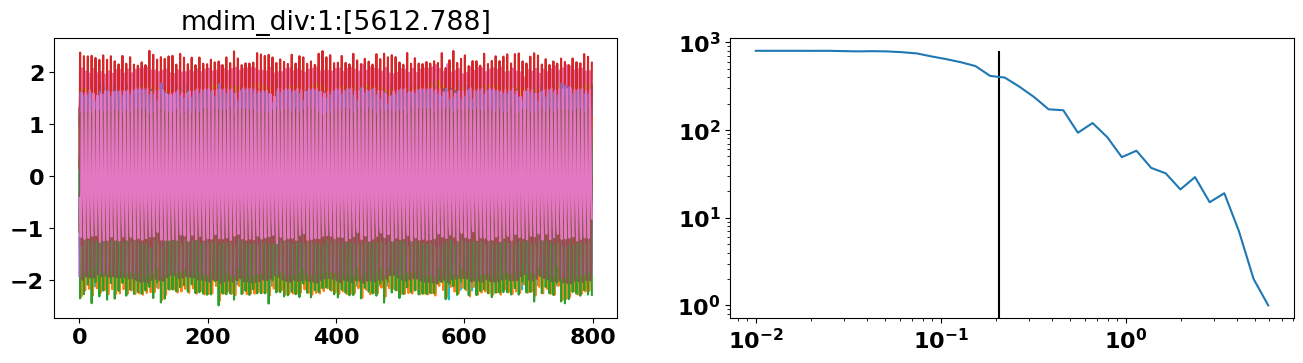

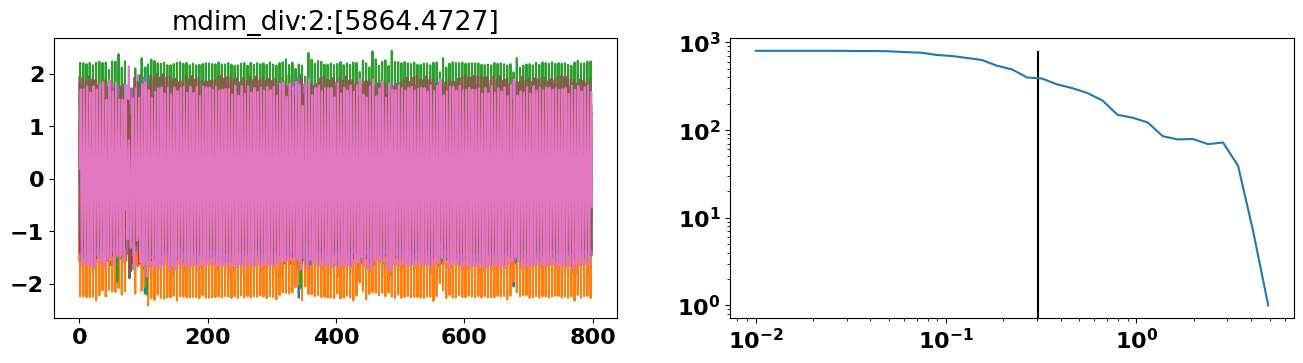

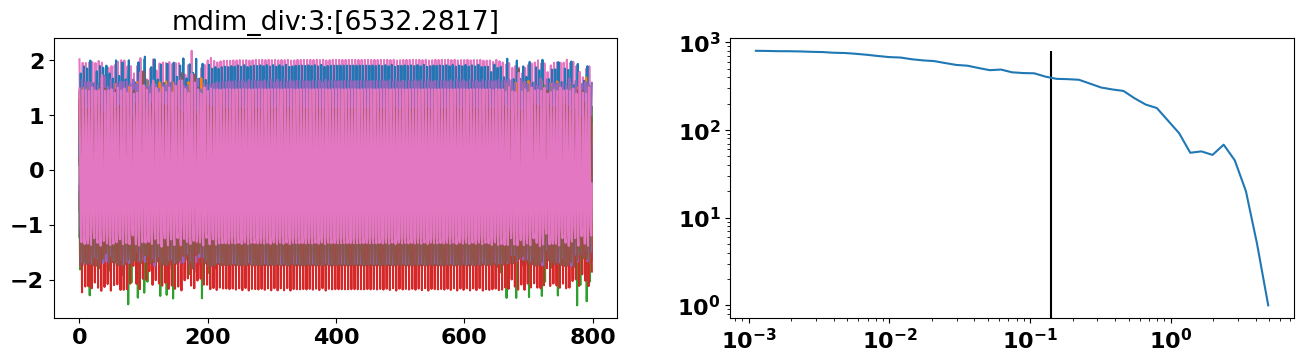

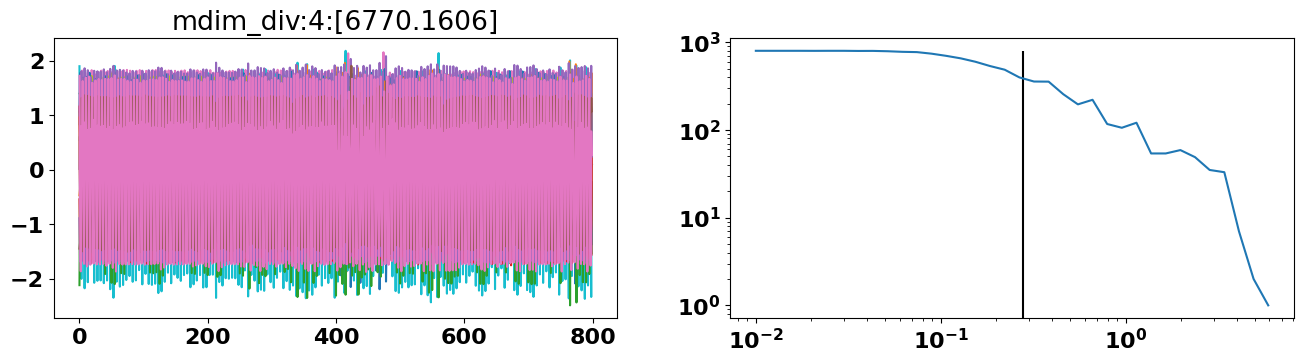

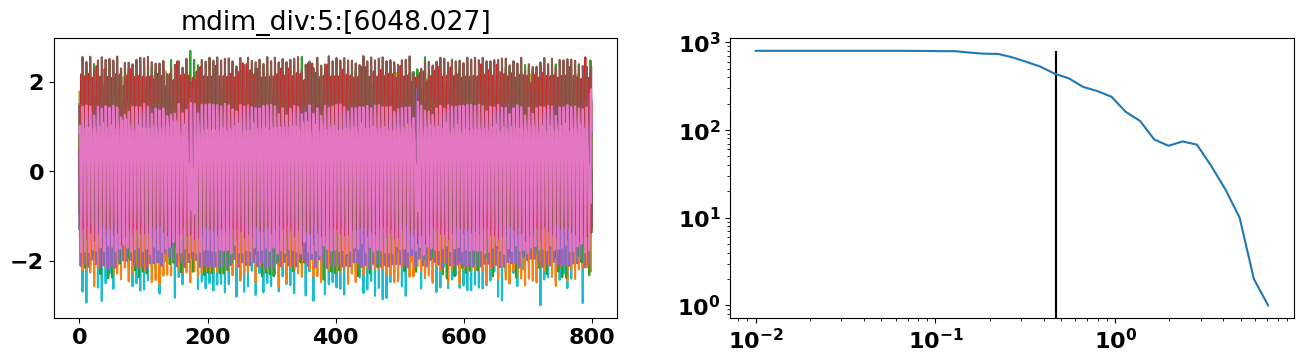

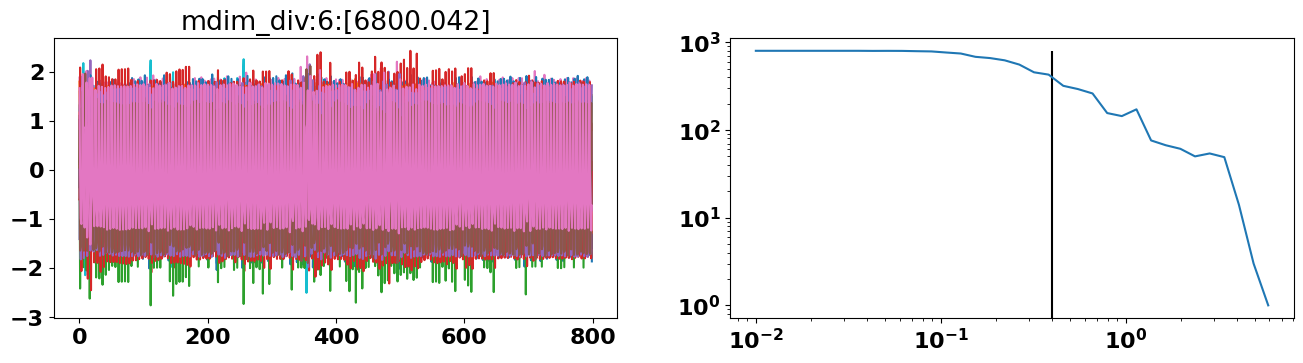

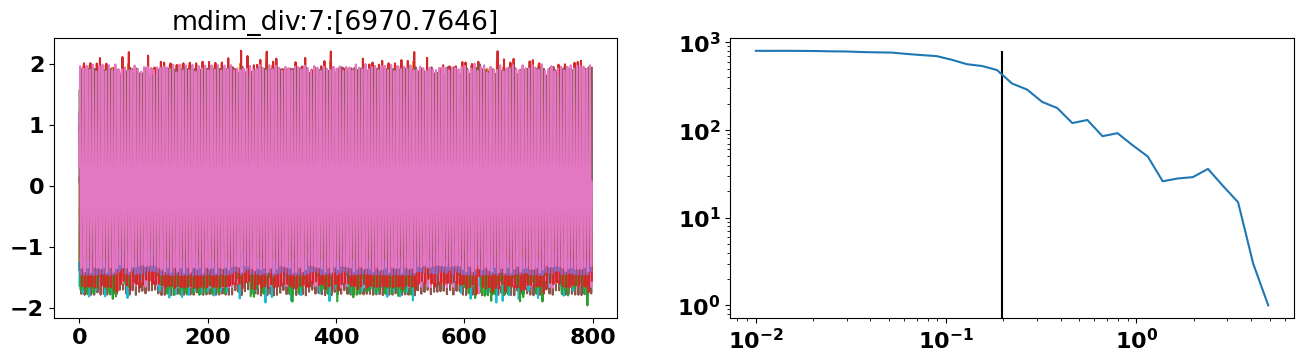

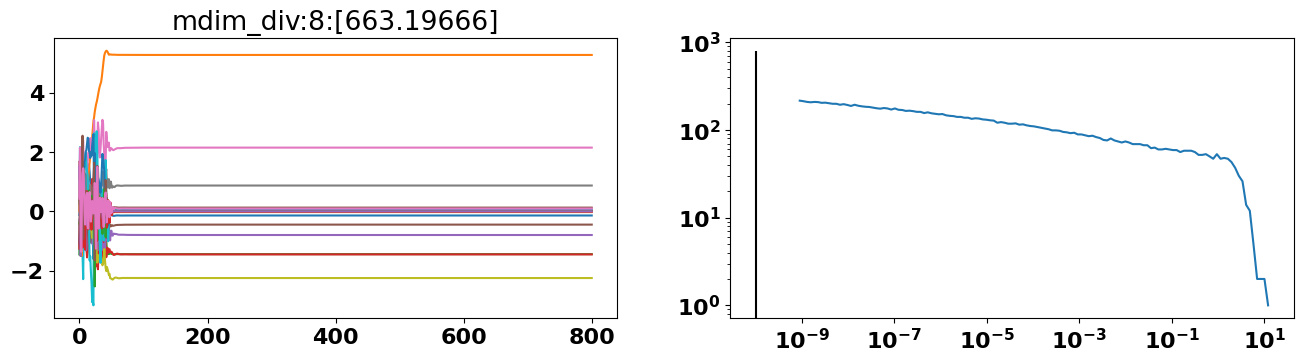

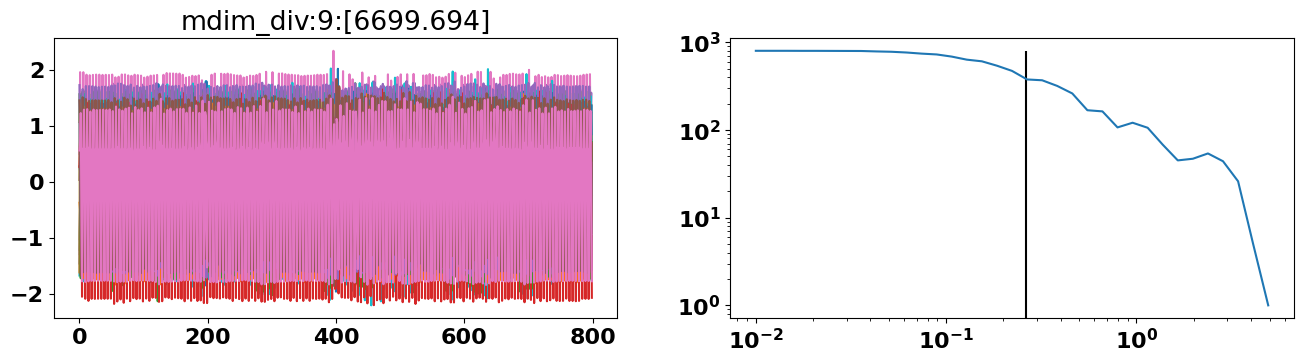

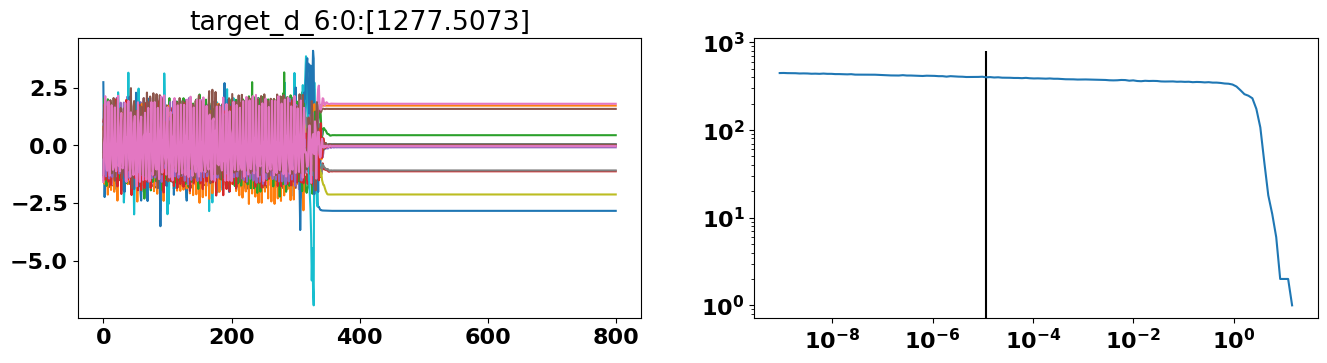

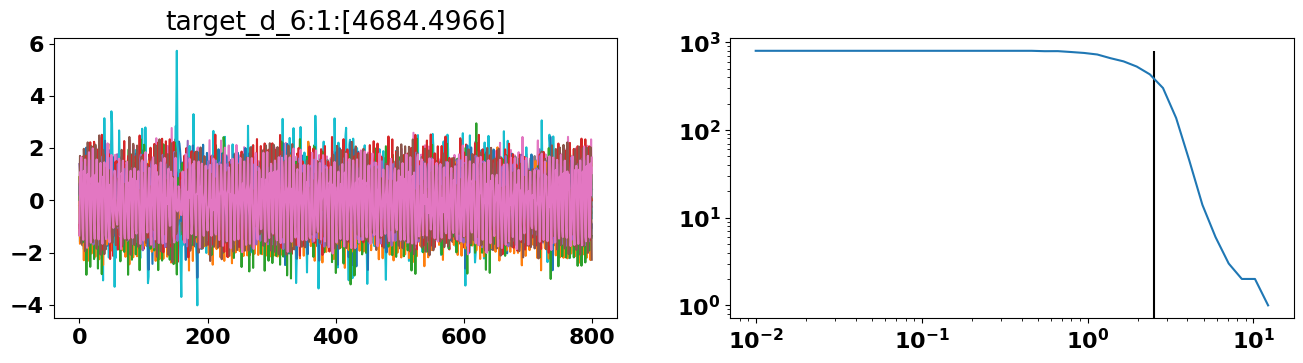

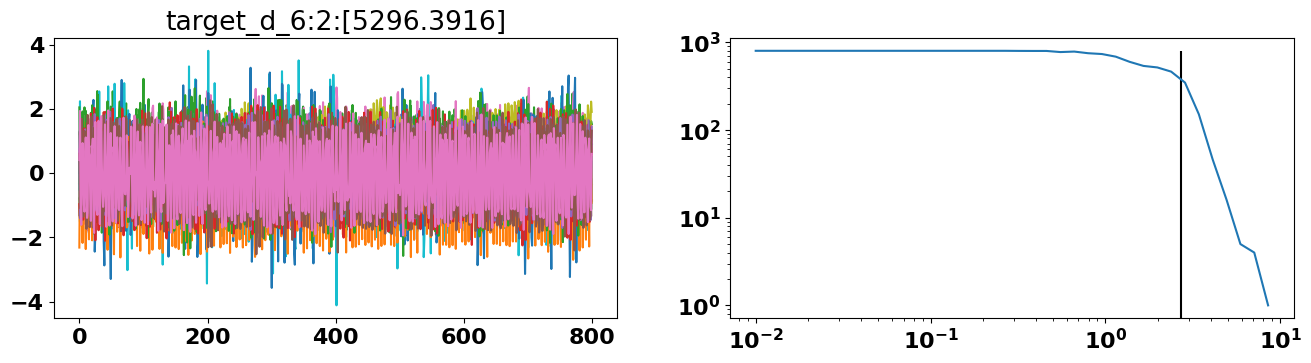

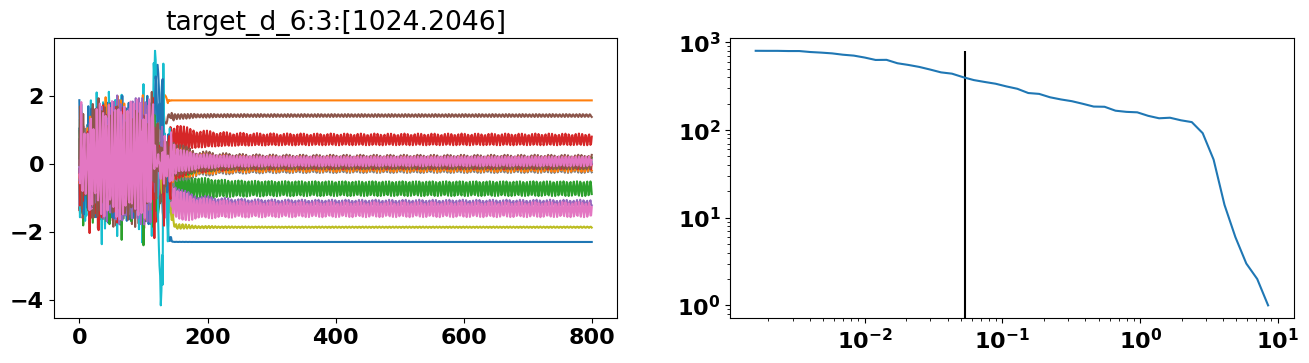

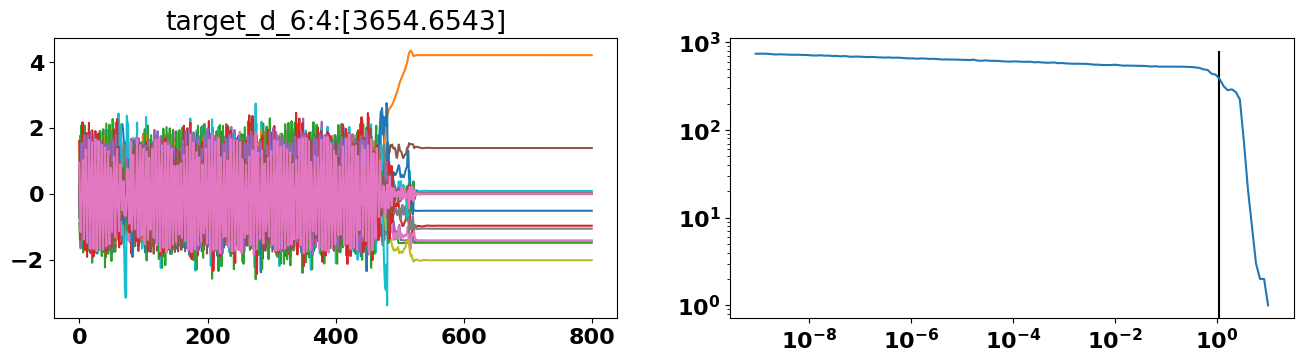

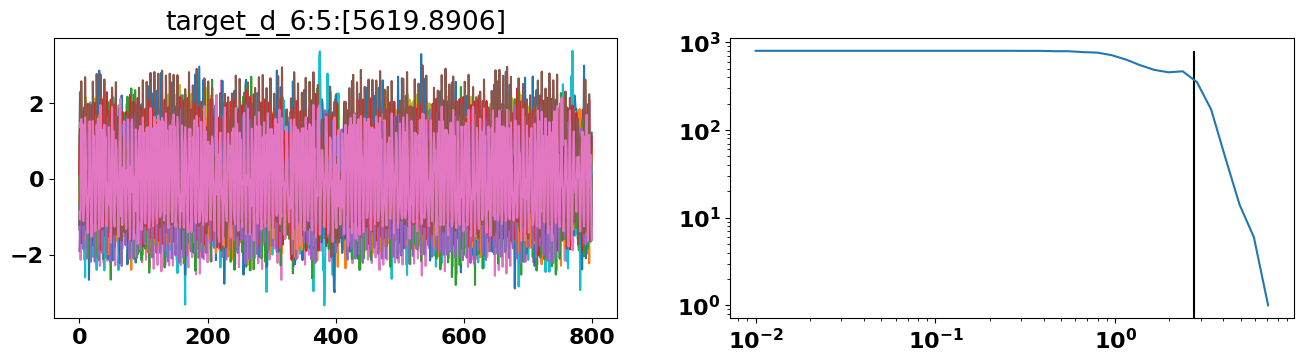

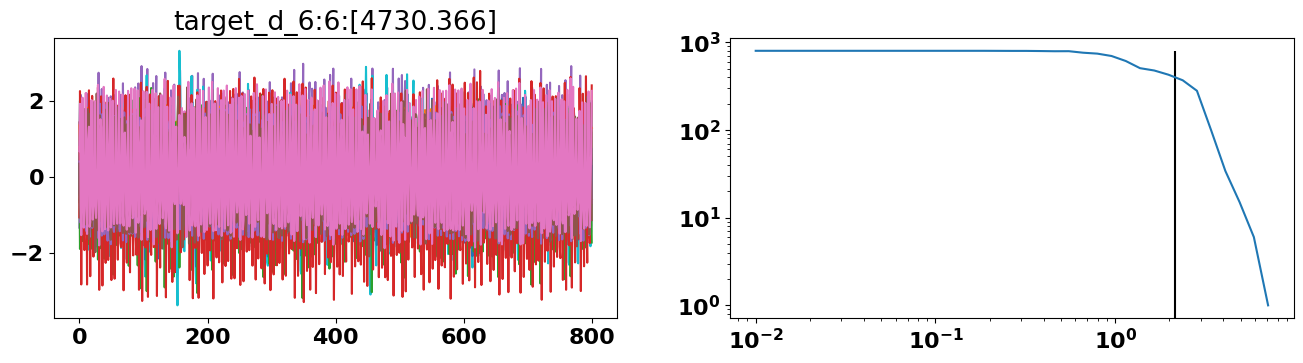

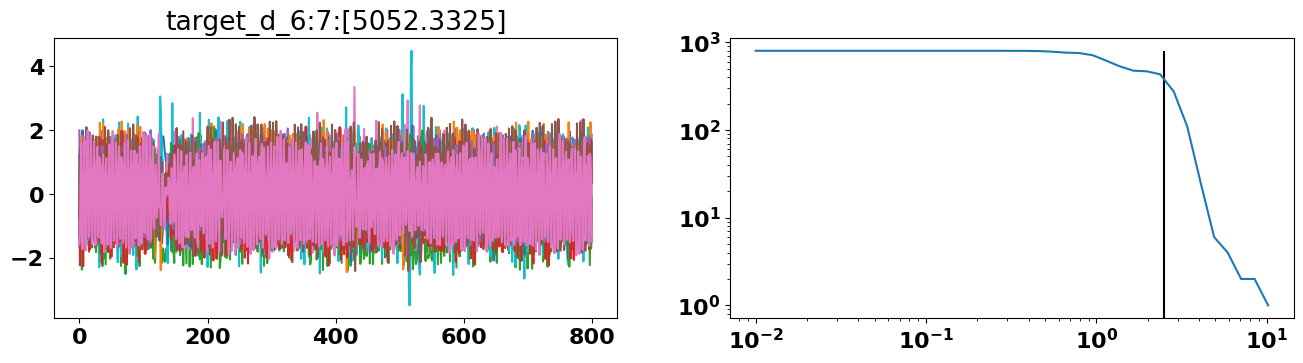

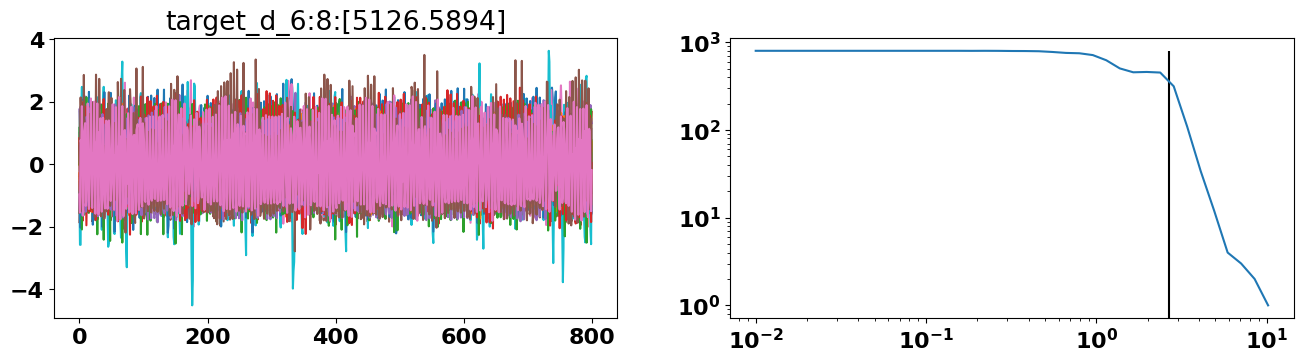

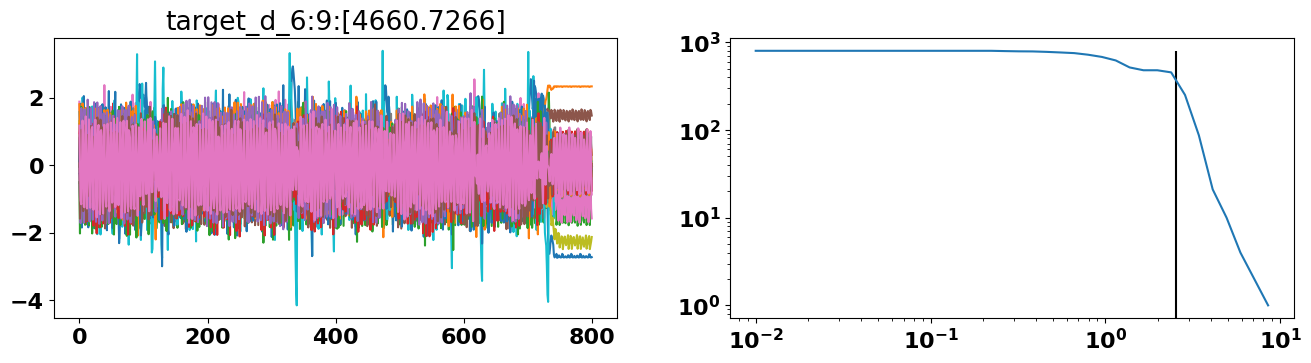

In [41]:
for post_fn in model_dict.keys():
    
    print(post_fn)
    print("======================================================")
    
    for seed in range(10):

        model = model_dict[post_fn][seed]

        plt.figure(figsize=(16,8))

        env = gym.make(env_name)

        o,a,r,d = do_rollout_noise(env, model, act_std=0, obs_std=0, num_steps=1000)
        print(any(d[:-1]))
        print(sum(r))

        plt.subplot(221)
        #plt.plot(o);
        plt.title(f"{post_fn}:{seed}:{sum(r)}")

        target = o[200:]
        target = (target - model.state_mean)/(model.state_std)
        #target = (target - target.mean(dim=0))/target.std(dim=0)
        plt.plot(target);


        mdim, cdim , m, b = mesh_dim(target, init_d=1e-2)
        print(mdim, cdim)


        target_d  = mesh_find_target_d(target)
        print(target_d)
        plt.subplot(222)
        plt.loglog(b,m);
        plt.vlines(target_d,0,target.shape[0])





In [47]:
env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"]#, "Ant-v2"]
init_names = ["identity", "identity", "identity"]#, "identity"]

#env_names = ["Ant-v2"]
#init_names = ["identity"]

#env_names = ['Humanoid-v2']
#init_names = ["identity"]

#post_names= ['init', 'mdim_div', 'cdim_div']
#post_fns = [mdim_div, cdim_div]


post_names = ['init', 'identity', 'mdim_div', 'target_d_div', 'target_d_divn']
post_fns =            [identity, mdim_div, target_d_div, target_d_divn]

#post_names = ['init', 'target_d_6']
#post_fns = [target_d_6]

init_d = 1e-6
num_runs = 5; num_seeds=10
ep_length= 1000


#post_names= ['init', 'mdim_div', 'cdim_div']
#post_fns = [mdim_div, cdim_div]


for env_name, init_name in zip(env_names, init_names):

    env = gym.make(env_name)
    #init_data = torch.load(f"./data_noise1/{env_name}.xr")
    init_data = torch.load(f"{save_dir}{env_name}/data.xr")

    init_model_dict = init_data.model_dict
    
    #data = torch.load(f"./data_noise1_mdim/{env_name}.xr")
    data = torch.load(f"./{mdim_save_dir}{env_name}/data.xr")

    model_dict = data.model_dict
        
    mshdims = xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    cdims =  xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    tds =  xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    rews =  xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})
    
    dones =  xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})
    

    
    for post_fn in post_fns:
        for i in range(num_seeds):
            for j in range(num_runs):
                model = model_dict[post_fn.__name__][i]
                o,a,r,d = do_rollout_noise(env, model, act_std=0, obs_std=0, num_steps=ep_length)
                target = o[200:]
                #target = (target - target.mean(dim=0))/target.std(dim=0)

                target = (target - model.state_mean)/(model.state_std)
             
                rews.loc[post_fn.__name__,i,j] = sum(r).item()

                mshdims.loc[post_fn.__name__,i,j], cdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target, init_d=init_d)
                tds.loc[post_fn.__name__,i,j] = mesh_find_target_d(target)
                dones.loc[post_fn.__name__,i,j] = any(d[:-1])
                
    
    for i in range(num_seeds):
        for j in range(num_runs):
            model = init_model_dict[init_name][i]
            o,a,r,d = do_rollout_noise(env, model, act_std=0, obs_std=0, num_steps=ep_length)

            #o,a,r,l = do_long_rollout(env, model, ep_length=ep_length)
            target = o[200:]
            target = (target - model.state_mean)/(model.state_std)
            #target = (target - target.mean(dim=0))/target.std(dim=0)


            rews.loc[post_names[0],i,j] = sum(r).item()

            mshdims.loc[post_names[0],i,j], cdims.loc[post_names[0],i,j] , _, _ = mesh_dim(target, init_d=init_d)
            tds.loc[post_names[0],i,j] = mesh_find_target_d(target)
            dones.loc[post_names[0],i,j] = any(d[:-1])


            
    print(f"{env_name}-----------------------------------------")

    print()
    print("mesh dimension")
    for name in post_names:
        mean = mshdims.mean(dim=('seed','run')).loc[name].item()
        std = mshdims.std(dim=('seed','run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("cmesh dimension")
    for name in post_names:
        mean = cdims.mean(dim=('seed', 'run')).loc[name].item()
        std = cdims.std(dim=('seed', 'run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")
        
    print()
    print("target ds")
    for name in post_names:
        mean = tds.mean(dim=('seed', 'run')).loc[name].item()
        std = tds.std(dim=('seed', 'run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("rewards")
    for name in post_names:
        mean = rews.mean(dim=('seed', 'run')).loc[name].item()
        std = rews.std(dim=('seed', 'run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print(); print()

HalfCheetah-v2-----------------------------------------

mesh dimension
init mean: 1.119883770803415, std: 0.23503007982453084
identity mean: 0.36064760054773903, std: 0.47487618912177526
mdim_div mean: 0.882110144528893, std: 0.16828217735288142
target_d_div mean: 0.16015486572467424, std: 0.26537245835759776
target_d_divn mean: 0.6488311137696288, std: 0.49293295205817533

cmesh dimension
init mean: 8.294317107459843, std: 1.9061921448406483
identity mean: 2.781718342170937, std: 3.2560195637948084
mdim_div mean: 7.5432331536426105, std: 1.4339076057073596
target_d_div mean: 5.32038359655549, std: 1.7179650951712586
target_d_divn mean: 6.585728598182165, std: 2.7179817072050407

target ds
init mean: 0.5768980682838519, std: 0.30682880063350937
identity mean: 0.14870658526735145, std: 0.24953707029588915
mdim_div mean: 0.2822454215067845, std: 0.1252387046708537
target_d_div mean: 0.11647742996569628, std: 0.30165393706178534
target_d_divn mean: 0.30865685353433714, std: 0.35943543472

In [45]:
mshdims.where(dones==0).mean(dim=('run', 'seed'))

<xarray.DataArray (post: 5)>
array([1.10243015, 0.39614231, 0.86441227, 0.19246933, 0.6792189 ])
Coordinates:
  * post     (post) <U13 'init' 'identity' ... 'target_d_div' 'target_d_divn'

In [ ]:
cdims.where(dones!=1).mean(dim=('run', 'seed'))

In [ ]:
dones.mean(dim=('run'))

In [ ]:
env_names = ["Walker2d-v2"]
init_names = ["identity"]

init_d = 1e-6
num_runs = 5; num_seeds=10
ep_length= 1000

post_names= ['cdim_div', 'mdim_div']
post_fns = [cdim_div, mdim_div]

walking_seeds = {'cdim_div': [0,1,3,4,5,8], 'mdim_div':[0,1,3,4,5,6,8,9]}

for env_name, init_name in zip(env_names, init_names):
    env = gym.make(env_name)
    init_data = torch.load(f"./data17/{env_name}.xr")
    init_model_dict = init_data.policy_dict
    
    data = torch.load(f"./data_mcshdim4/{env_name}.xr")
    policy_dict = data.policy_dict
    policy_dict['identity'] = init_policy_dict['identity']
        
    mshdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    cdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    vdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    mdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    rdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    rews =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    
    for post_fn in post_fns:
        for i in walking_seeds[post_fn.__name__]:
            for j in range(num_runs):
                policy = policy_dict[post_fn.__name__][i]
                o,a,r,l = do_rollout_noise(env, policy, act_std=0.01, obs_std=0.001, num_steps=ep_length)

                #o,a,r,l = do_long_rollout(env, policy, ep_length=ep_length)
                target = o[200:]
                target = (target - policy.state_means)/(policy.state_std)
             
                rews.loc[post_fn.__name__,i,j] = sum(r).item()

                mshdims.loc[post_fn.__name__,i,j], cdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target, init_d=1e-6)
                #mdims.loc[post_fn.__name__,i,j] = variation_dim(target)
                #vdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=2)
                #rdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=.5)
                
    

    print(f"{env_name}:")           
    print("madogram dimension")
    for name in post_names:
        mean = mdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = mdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("variogram dimension")
    for name in post_names:
        mean = vdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = vdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

#     print()
#     print("rodogram dimension")
#     for name in post_names:
#         mean = rdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
#         std = rdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
#         print(f"{name} mean: {mean}, std: {std}")

    print()
    print("mesh dimension")
    for name in post_names:
        mean = mshdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = mshdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("cmesh dimension")
    for name in post_names:
        mean = cdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = cdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("rewards")
    for name in post_names:
        mean = rews.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = rews.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print(); print()

In [ ]:
env_name = "HalfCheetah-v2"
init_data = torch.load(f"./data17/{env_name}.xr")
init_policy_dict = init_data.policy_dict

data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
seed = 2
ep_length = 10000
policy = policy_dict['identity'][seed]
env = gym.make(env_name)
%time o,a,r,_ = do_long_rollout(env, policy, ep_length= ep_length)
#o,a,r,l = do_rollout(env, policy, render=True)

plt.plot(o[1000:1050])
plt.figure()

target = o[200:]
target = (target - policy.state_means)/policy.state_std
#target = (target - policy.state_means)/policy.state_std
 
print(sum(r))
m,c,l,d = mesh_dim(target, init_d=1e-9, d_limit=1e-13)
print(m)
print(c)

In [ ]:
seed = 2
ep_length = 10000
policy = policy_dict['mdim_div'][seed]
env = gym.make(env_name)
%time o2,a2,r2,_ = do_long_rollout(env, policy, ep_length= ep_length)

plt.plot(o2[1000:1050])
plt.figure()

target2 = o2[200:]
target2 = (target2 - policy.state_means)/policy.state_std
#target = (target - policy.state_means)/policy.state_std
 
print(sum(r2))
m2,c2,l2,d2 = mesh_dim(target2, init_d=1e-9, d_limit=1e-13)
print(m2)
print(c2)

In [ ]:
seed = 2
ep_length = 10000
policy = policy_dict['cdim_div'][seed]
env = gym.make(env_name)
%time o3,a3,r3,_ = do_long_rollout(env, policy, ep_length= ep_length)

plt.plot(o3[1000:1050])
plt.figure()

target3 = o3[200:]
target3 = (target3 - policy.state_means)/policy.state_std
#target = (target - policy.state_means)/policy.state_std
 
print(sum(r3))
m3,c3,l3,d3 = mesh_dim(target3, init_d=1e-9, d_limit=1e-13)
print(m3)
print(c3)

In [ ]:
# plt.plot(np.log2(d2), np.array(l[:-1]) - np.array(l2),'x-')
# plt.title('log2(d) vs cdiv mesh size')
# plt.figure()

plt.figure(figsize=(12,4))
plt.plot(np.log2(d), l,'o-', color='r')
plt.plot(np.log2(d2), l2,'o-' ,color='k')
plt.plot(np.log2(d3), l3,'o-',color='b' )

plt.legend(['Identity', 'Lower Mesh Dim','Upper Mesh Dim'])
plt.title("log(d) vs mesh size, HalfCheetah-v2, seed 2")
plt.xlabel("log(d)")
plt.ylabel("mesh size")
plt.grid()



plt.figure()

plt.plot(d, l,'x-')
plt.plot(d2, l2,'x-')
plt.legend(['id', 'mdiv'])
plt.title("d vs mesh size")
plt.xlim([0,1])
plt.figure()

plt.plot(d[:-2], np.array(l[:-2]) - np.array(l3),'x-')
plt.plot(d[:-2], np.array(l[:-2]) - np.array(l2),'x-')
plt.xlim([0,1])

plt.plot(d3, l3,'x-')
plt.legend(['id', 'mdiv', 'cdiv'])
plt.title("d vs mesh size")
plt.xlim([0,1])
plt.figure()

In [ ]:
import time
for seed in range(num_seeds):
    fail=0
    for i in range(10):
        obs, acts, rews, _ = do_long_rollout(env, init_policy_dict['identity'][seed], ep_length=10000)
        #plt.plot(obs)
        if sum(rews) < 0:

        
            fail+=1
            
    print(seed,fail)

In [ ]:
plt.loglog(d2,l2,'o-')